# Machine Predictive Maintenance Data

------

## Part 3: Deep Learning

In the previous Jupyter Notebook, some machine learning models have been built by using RandomForestClassifier and GradientBoostingClassifier to perform prediction on machine failures. These models are able to achieve an accuracy of around 98%.  

In this notebook, **deep learning** will be used to achieve a similar purpose, hopefully with a better accuracy.  
- A simple Deep Neural Network (DNN) will be built first.
- The model will be tuned by adjusting the parameters such as layers, number of epochs, learning rates and so on. 

------

### 3a. Pre-modelling Data Processing

Firstly, the dataset is imported again, and some processings are performed so that the dataset can be fitted into the models later. 

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import joblib
import numpy as np  # Used in chart plotting during the learning rate tuning

In [2]:
# Import data
df_raw = pd.read_csv("dataset_raw.csv")

In [3]:
# Look at the top 10 rows of the data frame. 
df_raw.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure


In [4]:
# Confirm the data types of the columns
df_raw.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

- Based on the data exploration in the previous notebook, the columns "**UDI**" and "**Product ID**" are both identifier that are **unique for every record**. Therefore, they are **dropped** from the data frame because they won't be helpful in the classification models.  
- As for the column "**Failure Type**", it is also **dropped** as it provides detailed information about the machine failures, which conflicted with our purpose of predicting the "Target" column.  
- For Deep Learning, unlike in the previous notebook, the "**Target**" column will **NOT be converted to string**, as the output variable for binary classification in Tensorflow needs to be in numeric format (0 and 1). 

In [5]:
# Select only columns that we need. 
df_main = df_raw.drop(columns = ["UDI", "Product ID", "Failure Type"])
# df_main["Target"] = df_main["Target"].astype(str)

In [6]:
# Check the number of records for each Target value. 
df_main["Target"].value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

Similar to the machine learning models in scikit-learn, the deep learning models in Tensorflow are unable to handle categorical variables directly. Here the corresponding column (in this case only "Type" columns) are converted into **dummy variables**.  

In [7]:
# For categorical variables, convert them to dummy variables
df_main = pd.get_dummies(df_main, columns = ["Type"])
display(df_main.head(10))

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,False,False,True
1,298.2,308.7,1408,46.3,3,0,False,True,False
2,298.1,308.5,1498,49.4,5,0,False,True,False
3,298.2,308.6,1433,39.5,7,0,False,True,False
4,298.2,308.7,1408,40.0,9,0,False,True,False
5,298.1,308.6,1425,41.9,11,0,False,False,True
6,298.1,308.6,1558,42.4,14,0,False,True,False
7,298.1,308.6,1527,40.2,16,0,False,True,False
8,298.3,308.7,1667,28.6,18,0,False,False,True
9,298.5,309.0,1741,28.0,21,0,False,False,True


Now that the processing has been done for the content of the dataset, two more things to do is:  
- Splitting the full dataset into **output variable** (the variable that will be predicted) & **input variables** (variables that will be used to predict the output variable).
- Splitting both input & output variables into **training set** (the set of data that will be used to train the model) & **test set** (the set of data that will be used to test the accuracy or quality of the trained model). This split are usually done at a fixed ratio, which in this case **6:4 split** will be used for the training:test sets of data. 

In [8]:
# Split into input & output variables 
X = df_main.drop(columns = "Target")
y = df_main["Target"]

# Split into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=0)

------

### 3b. Deep Neural Network (DNN)

First, a simple model is created, and the training set of data is fitted into the model.  
After that, the fitted model is used to perform prediction on the test set of data, and then the accuracy is evaluated by comparing the predicted result with the actual result.  

At this stage, the model architecture used (number of layers and nodes) are arbitrary, and will be tuned later for a better performance. 

In [9]:
# Set a random seed first. 
tf.random.set_seed(42)

# Create, compile and fit the model. 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)
history = model.fit(X_train, y_train, epochs=200)

Epoch 1/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.8606 - loss: 9.9798 
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.9539 - loss: 0.2415
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.9605 - loss: 0.1491
Epoch 4/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.9572 - loss: 0.2021
Epoch 5/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.9564 - loss: 0.2313
Epoch 6/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.9612 - loss: 0.1523
Epoch 7/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.9604 - loss: 0.1991
Epoch 8/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.9582 - loss: 0.1654
Epoch 9/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.9595 - loss: 0.1709
Epoch 10/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.9596 - loss: 0.1705
Epoch 11/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.9627 - loss: 0.1306
Epoch 12/200
188/1

The final training accuracy of the model is at around 97.4%.  
The **model.summary()** function can be used to get a summary of the model architecture, including information about the layers, number of parameters and so on. 

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,541 (52.90 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,028 (35.27 KB)

By using the **model.evaluate()** function onto the test set of data, the performance of the model can be evaluated, based on the **loss function & metrics** specified during model compilation (in this case, **binary_crossentropy & accuracy** respectively).  
The **confusion matrix** is also created to better illustrate how the test set of data has been classified. 

In [11]:
# Evaluate the model to get loss function and accuracy. 
list_model_eval = model.evaluate(X_test, y_test, verbose = 0)  # Returns a list of 2 values, first one is loss and second one is accuracy. 
print("Loss (binary_crossentropy): " + str(list_model_eval[0]))
print("Accuracy: " + str(list_model_eval[1]))

# Perform prediction on the test data by using the trained model. 
y_pred = model.predict(X_test, verbose = 0)
# Convert y_pred from Sigmoid (0 to 1) to binary (0 and 1)
y_pred = [0 if i < 0.5 else 1 for i in y_pred]
# Create confusion matrix
display(pd.crosstab(y_test, y_pred))

Loss (binary_crossentropy): 0.08193967491388321
Accuracy: 0.9754999876022339


col_0,0,1
Target,,
0,3843,34
1,64,59


The accuracy obtained from the basic DNN model is at ~97.5%, which is slightly lower than the machine learning models in the previous notebook. 

There are a few methods that can possibly improve the performance of the model. These are a few that can be attempted:  
- Adjusting the **number of epochs** used to train the model.  
- Using different **model optimizer** and **learning rates**.  
- Changing the **model architecture**, as in the layers used in the model and their respective parameters.  

------

### 3c. Adjusting the Number of Epochs. 

The model above was trained by using 200 epochs, which is just an arbitrary number. A better performance may be achievable with a lower or higher number of epochs.  
Here, a **chart** is plotted to illustrate the **accuracy and loss values** of the model in each epoch.  

In [12]:
# Code referenced from DeepLearning.io training material 
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    # val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    # val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    # plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training accuracy')
    
    plt.figure()
    
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    # plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training loss')
    plt.legend()
    
    plt.show()

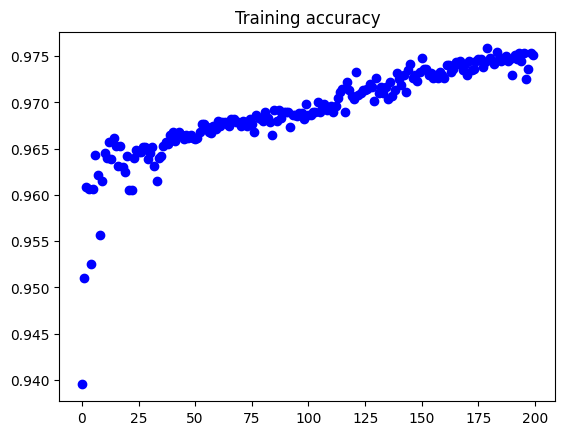

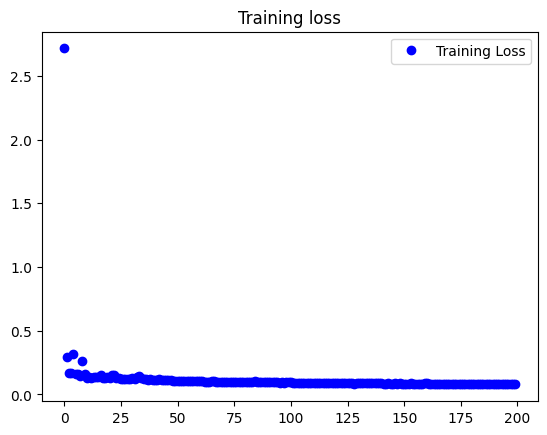

In [13]:
plot_loss_acc(history)

From the training accuracy plot, it can be seen that the accuracy is slowly increasing with the epochs, and it seems that it **could be better if more apochs were trained**.  
Therefore, the same model is trained again with **500 epochs** instead, and the same evaluations will be performed again. 

In [14]:
# Set a random seed first. 
tf.random.set_seed(42)

# Create, compile and fit the model. 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)
history = model.fit(X_train, y_train, epochs=500)

Epoch 1/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.7752 - loss: 38.2988 
Epoch 2/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.9537 - loss: 0.2546
Epoch 3/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.9600 - loss: 0.2075
Epoch 4/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.9606 - loss: 0.1669
Epoch 5/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.9557 - loss: 0.2142
Epoch 6/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.9557 - loss: 0.2286
Epoch 7/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.9562 - loss: 0.1739
Epoch 8/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.9542 - loss: 0.1777
Epoch 9/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.9542 - loss: 0.2011
Epoch 10/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.9523 - loss: 0.1928
Epoch 11/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.9586 - loss: 0.1509
Epoch 12/500
188/

In [15]:
# Evaluate the model to get loss function and accuracy. 
list_model_eval = model.evaluate(X_test, y_test, verbose = 0)  # Returns a list of 2 values, first one is loss and second one is accuracy. 
print("Loss (binary_crossentropy): " + str(list_model_eval[0]))
print("Accuracy: " + str(list_model_eval[1]))

# Perform prediction on the test data by using the trained model. 
y_pred = model.predict(X_test, verbose = 0)
# Convert y_pred from Sigmoid (0 to 1) to binary (0 and 1)
y_pred = [0 if i < 0.5 else 1 for i in y_pred]
# Create confusion matrix
display(pd.crosstab(y_test, y_pred))

Loss (binary_crossentropy): 0.08005280047655106
Accuracy: 0.9794999957084656


col_0,0,1
Target,,
0,3857,20
1,62,61


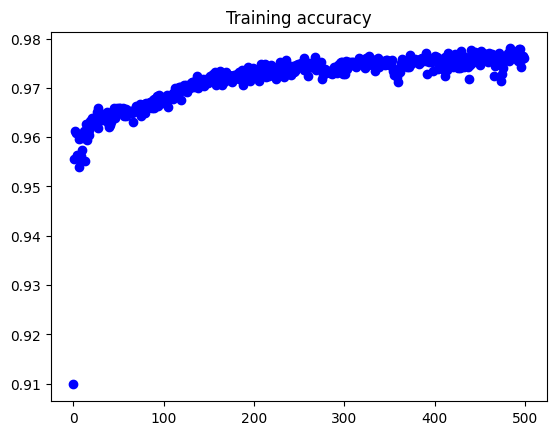

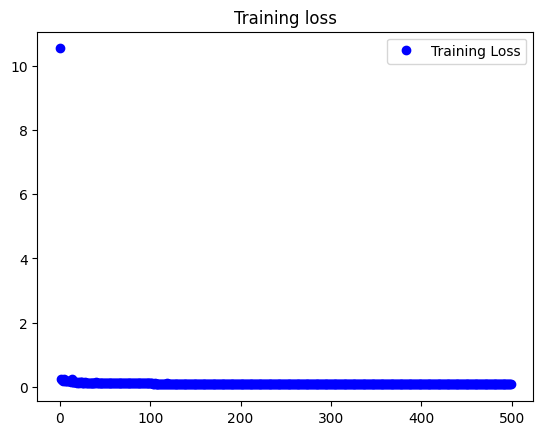

In [16]:
plot_loss_acc(history)

As there are now more epochs to train, the training took a longer time, and therefore a better performance was expected.  
The accuracy obtained here is around 97.9%, slightly better than before, but not as good as the machine learning models yet. 

------

### 3d. Using Different Model Architectures

Very often, a more complex model architecture may be required to solve a more complex problem, while a simple model architecture may perform better in the case of a simple problem.  
A few approaches can be taken to modify the model architecture, to find one that fits this use case better.  
- Increase the number of nodes in existing layers.
- Reduce the number of nodes in existing layers.
- Using less number of layers.
- Adding more Dense and/or Dropout layers. 

After performing some testings separately, here are the accuracies of some models trained with different approaches mentioned above:  
- Reduced number of nodes: 97.7%  
- Increased number of nodes: 97.4%  
- Reduced number of layers: 98.1%  
- Increased number of layers (plus Dropout layers): 98%  

In this section, the model architecture that performed the best is the one with **reduced number of layers**. The model fitting process is shown below.  
A function is also defined with the finalized model architecture to ease new model initialization in the following sections. 

In [21]:
# Set a random seed first. 
tf.random.set_seed(42)

# Create, compile and fit the model. 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)
history = model.fit(X_train, y_train, epochs=500)

Epoch 1/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - accuracy: 0.9393 - loss: 3.6734
Epoch 2/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.9438 - loss: 0.3576
Epoch 3/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.9461 - loss: 0.2266
Epoch 4/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.9479 - loss: 0.2575
Epoch 5/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.9475 - loss: 0.3699
Epoch 6/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.9522 - loss: 0.2297
Epoch 7/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.9467 - loss: 0.4169
Epoch 8/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.9482 - loss: 0.5071
Epoch 9/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.9533 - loss: 0.3295
Epoch 10/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.9552 - loss: 0.1722
Epoch 11/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.9497 - loss: 0.4899
Epoch 12/500
188/18

In [22]:
# Evaluate the model to get loss function and accuracy. 
list_model_eval = model.evaluate(X_test, y_test, verbose = 0)  # Returns a list of 2 values, first one is loss and second one is accuracy. 
print("Loss (binary_crossentropy): " + str(list_model_eval[0]))
print("Accuracy: " + str(list_model_eval[1]))

# Perform prediction on the test data by using the trained model. 
y_pred = model.predict(X_test, verbose = 0)
# Convert y_pred from Sigmoid (0 to 1) to binary (0 and 1)
y_pred = [0 if i < 0.5 else 1 for i in y_pred]
# Create confusion matrix
display(pd.crosstab(y_test, y_pred))

Loss (binary_crossentropy): 0.07960149645805359
Accuracy: 0.9810000061988831


col_0,0,1
Target,,
0,3867,10
1,66,57


In [26]:
# Use a function to return a new model with the best model architecture tested above. 
def best_model_architecture():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model 

------

### 3e. Model Optimizer and Learning Rate Tuning

Another thing that can be done to improve the model is to use a different model optimizer or learning rate to train the model across the epochs,  
Again, the models above were trained using an arbitrary model optimizer (Adam) and the default learning rate (0.001).  

Here, the **LearningRateScheduler** will be used to **identify an optimal learning rate** that can be used to optimize the model. Basically, what it will do is that during the model fitting process, the **learning rate will be adjusted on each epochs**. 

#### Adam Optimizer

In [27]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 50)
)

In [28]:
# Set a random seed first. 
tf.random.set_seed(42)

# Create, compile and fit the model. 
model_tune = best_model_architecture()
model_tune.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)
history = model_tune.fit(X_train, y_train, epochs=500, callbacks=[lr_schedule])

Epoch 1/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step - accuracy: 0.0372 - loss: 451.1547 - learning_rate: 1.0000e-08
Epoch 2/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - accuracy: 0.0372 - loss: 451.1040 - learning_rate: 1.0471e-08
Epoch 3/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.0372 - loss: 451.0529 - learning_rate: 1.0965e-08
Epoch 4/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.0372 - loss: 450.9997 - learning_rate: 1.1482e-08
Epoch 5/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.0372 - loss: 450.9407 - learning_rate: 1.2023e-08
Epoch 6/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.0372 - loss: 450.8813 - learning_rate: 1.2589e-08
Epoch 7/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.0372 - loss: 450.8211 - learning_rate: 1.3183e-08
Epoch 8/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.0372 - loss: 450.7590 - learning_rate: 1.3804e-08
Epoch 9/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 626u

Then, a chart is plotted to illustrate the **loss function value at each learning rate**.  

(1e-08, 100.0, 0.0, 1.0)

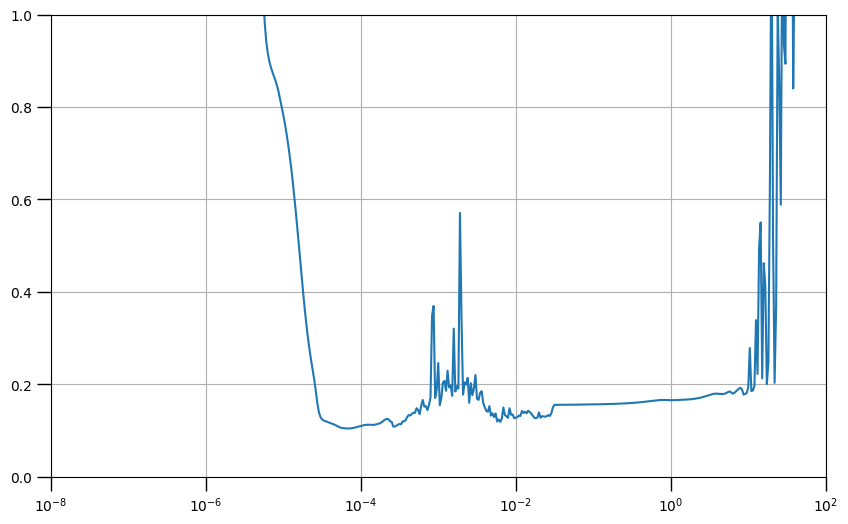

In [29]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(500) / 50))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params(axis='both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e2, 0, 1])

The optimal learning rate is identified by locating the **lowest smoother values** in the curve, and at the same time having a **downward slope**. Doing this may help the model **training converge to that loss value quicker**.  
Based on the plot above, one suitable learning rate value would be somewhere around **2e-4**. With this, the same model will be trained again with this learning rate. A higher number of epochs will also be used to cater for the lower learning rate. 

In [31]:
# Set a random seed first. 
tf.random.set_seed(42)

# Create, compile and fit the model. 
model = best_model_architecture()
model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4),
    metrics = ["accuracy"]
)
history = model.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - accuracy: 0.7541 - loss: 9.0023
Epoch 2/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - accuracy: 0.9612 - loss: 0.2206
Epoch 3/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.9563 - loss: 0.2116
Epoch 4/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.9572 - loss: 0.2025
Epoch 5/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - accuracy: 0.9600 - loss: 0.1836
Epoch 6/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.9590 - loss: 0.1630
Epoch 7/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - accuracy: 0.9615 - loss: 0.1518
Epoch 8/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.9597 - loss: 0.1469
Epoch 9/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.9596 - loss: 0.1427
Epoch 10/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.9601 - loss: 0.1412
Epoch 11/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.9600 - loss: 0.1414
Epoch 12

In [32]:
# Evaluate the model to get loss function and accuracy. 
list_model_eval = model.evaluate(X_test, y_test, verbose = 0)  # Returns a list of 2 values, first one is loss and second one is accuracy. 
print("Loss (binary_crossentropy): " + str(list_model_eval[0]))
print("Accuracy: " + str(list_model_eval[1]))

# Perform prediction on the test data by using the trained model. 
y_pred = model.predict(X_test, verbose = 0)
# Convert y_pred from Sigmoid (0 to 1) to binary (0 and 1)
y_pred = [0 if i < 0.5 else 1 for i in y_pred]
# Create confusion matrix
display(pd.crosstab(y_test, y_pred))

Loss (binary_crossentropy): 0.08639703691005707
Accuracy: 0.9779999852180481


col_0,0,1
Target,,
0,3854,23
1,65,58


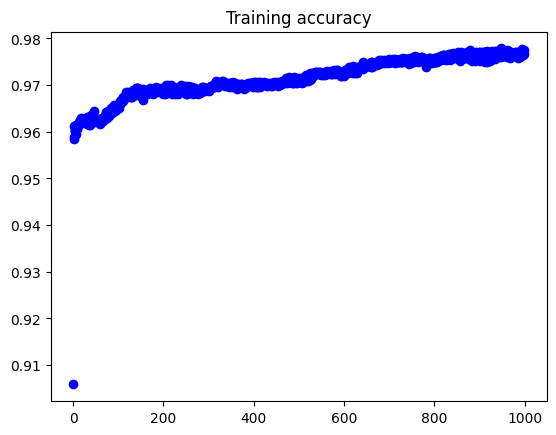

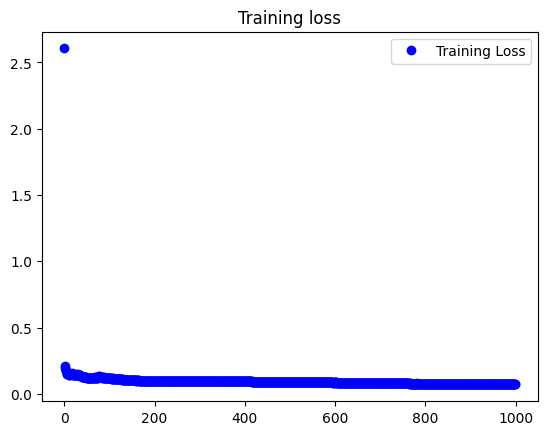

In [33]:
plot_loss_acc(history)

Prediction from the latest model gives an accuracy of around 97.8%, which is unfortunately not as good as the previous model. 

Some testings were also done separately with different model optimizers (RMSprop and SGD), and their performances are also not as good. This is probably because the models have overfitted to the training set of data. 

------

### 3f. Saving Models into .h5 files. 

After getting a model that has a satisfying performance, **the model can be saved into a .h5** file.  
By doing this, the model can be imported and directly put into use in future, without the need to re-train it from scratch.  

Similar to the machine learning models in the previous notebook, it is safer to **save the input variable sequence** into a separate text file for reference, to make sure that the model can work properly in future. The step is not performed here as the column sequence is the same as the one used and saved in the previous notebook. 

In [47]:
# save model
model.save('myModel.h5')

With the dump function above, the files are successfully saved into the local folder.  
To import the files in future, the load function can be used as follows. 

In [49]:
from tensorflow.keras.models import load_model

# load model
savedModel=load_model('myModel.h5')

In [50]:
savedModel.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                     │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,379 (5.39 KB)

 Trainable params: 1,377 (5.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

------

To summarize, in this notebook, Neural Network is used to perform classification for the machine failure prediction dataset.  

Although various approaches have been taken to optimize the model, the **final accuracy** is **slightly lower**, but almost similar, to the accuracy obtained from the **machine learning models** in the previous notebook. On top of that, **more resources** (processing power & time taken) are required to **train the neural network models** compared to the machine learning models.  

Therefore, for this machine failure prediction problem, **machine learning model is a more suitable choice** to be used for the failure prediction.  
Neural Network models can also be used for this problem, but its performance may be better in performing a more complex task, such as image classification or natural language processing. 